In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt

# Exercises:

### a. MDCT:
In this exercise you will implement a time-to-frequency mapping using the MDCT. You will verify that the mapping leads to perfect reconstruction and that the fast implementation is significantly faster than straightforward implementation. Your fast MDCTIIMDCT implementation will be useful for later exercises.
1. Program functions to carry out the MDCT and IMDCT using the transform definitions.

In [2]:
class MDCT():
    def __init__(self, N: int, window: np.ndarray):
        K = N//2
        self.n_0 = ((N/2) + 1)/2

        A = np.zeros((K,N))
        for k in range(K):
            for n in range(N):
                A[k,n] = np.cos((2*np.pi/N)*(n + self.n_0)*(k+1/2))

        self.N = N
        self.window = window
        self.A_1 = A[:,:N//2]
        self.A_2 = A[:,N//2:]
        self.B_1 = (4/N)*self.A_1.T
        self.B_2 = (4/N)*self.A_2.T

        self.A = A
        self.B = (4/N)*A.T

        if window.shape[0] != N:
            raise ValueError(f"Window is not the same size as N! Window size: {window.shape[0]}")

    def _preprocess(self, x: np.ndarray):
        L = len(x)
        self.frames = L//(self.N//2) + 1
        r = L%(self.N//2)
        return np.pad(x, (self.N // 2, self.N // 2 - r))


    def mdct(self, x: np.ndarray):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = self.A @ (frame * self.window)

        return X

    def imdct(self, X: np.ndarray):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += (self.B @ X[:,frame_idx]) * self.window
            
        return x_padded[self.N//2:-self.N//2]
    
    def mdct_pre_twiddle(self):
        return np.exp(-2j * np.pi * np.arange(self.N) / (2*self.N))

    def mdct_post_twiddle(self):
        return np.exp(-2j * np.pi * self.n_0 * (np.arange(self.N//2) + 0.5) / self.N)


    def mdct_via_fft(self, x):
        x_padded = self._preprocess(x)

        X = np.ndarray((self.A.shape[0], self.frames))
        for frame_idx in range(self.frames):
            frame = x_padded[frame_idx*(self.N//2):frame_idx*(self.N//2)+self.N]
            X[:, frame_idx] = np.real(
                self.mdct_post_twiddle() * np.fft.fft(frame * self.window * self.mdct_pre_twiddle())[:self.N//2]
            )
        
        return X 
    
    def imdct_pre_twiddle(self):
        return np.exp(2j * np.pi * self.n_0 * np.arange(self.N) / self.N)

    def imdct_post_twiddle(self):
        return np.exp(2j * np.pi * (np.arange(self.N) + self.n_0) / (2*self.N))
    
    def imdct_via_ifft(self, X):
        x_padded = np.zeros(self.frames * self.N//2 + self.N//2)
        for frame_idx in range(self.frames):
            x_padded[frame_idx*self.N//2:frame_idx*self.N//2 + self.N] += \
            np.real(np.fft.ifft(np.concatenate((X[:,frame_idx], -X[::-1,frame_idx])) * self.imdct_pre_twiddle()) * \
            self.imdct_post_twiddle()) * 2 * self.window
            
        return x_padded[self.N//2:-self.N//2]

In [3]:
def sine_window(N):
    M = N//2
    w = np.zeros((N,1))

    for n in range(N-M):
        w[n] = np.sin((np.pi/2)*(n+1/2)/(N-M))
        
    for n in range(N-M,M):
        w[n] = 1

    for n in range(M,N):
        w[n] = np.sin((np.pi/2)*(N - n - 1/2)/(N-M))

    return w.reshape(-1)

In [4]:
N = 32
k = 5
n_0 = ((N/2) + 1)/2
x = np.cos((2*np.pi/N)*(np.arange(N) + n_0)*(k+1/2))

mdct: 0.0003082752227783203
mdct_fft: 0.0010094642639160156
imdct: 0.00011396408081054688
imdct_fft: 0.0004150867462158203
erro: 2.7755575615628914e-16
erro_fft: -4.371503159461554e-16


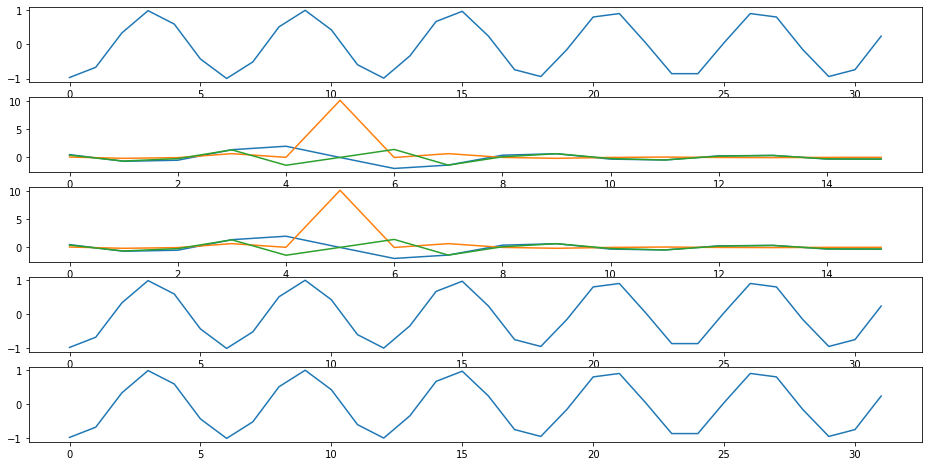

In [5]:
my_mdct = MDCT(N, sine_window(N))

mdct_start = time.time()
X = my_mdct.mdct(x)
mdct_end = time.time()
print(f'mdct: {mdct_end - mdct_start}')

mdct_fft_start = time.time()
X_fft = my_mdct.mdct_via_fft(x)
mdct_fft_end = time.time()
print(f'mdct_fft: {mdct_fft_end - mdct_fft_start}')

imdct_start = time.time()
x_hat = my_mdct.imdct(X)
imdct_end = time.time()
print(f'imdct: {imdct_end - imdct_start}')

imdct_fft_start = time.time()
x_hat_fft = my_mdct.imdct_via_ifft(X_fft)
imdct_fft_end = time.time()
print(f'imdct_fft: {imdct_fft_end - imdct_fft_start}')

print(f'erro: {(x - x_hat).sum()}')
print(f'erro_fft: {(x - x_hat_fft).sum()}')
fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize=(16, 8))
ax[0].plot(x)
ax[1].plot(X)
ax[2].plot(X_fft)
ax[3].plot(x_hat)
ax[4].plot(x_hat_fft)

mdct: 0.029204368591308594
mdct_fft: 0.012128353118896484
imdct: 0.025108814239501953
imdct_fft: 0.018419265747070312
erro: -3.539087425896703e-13
erro_fft: -4.371863114582819e-13


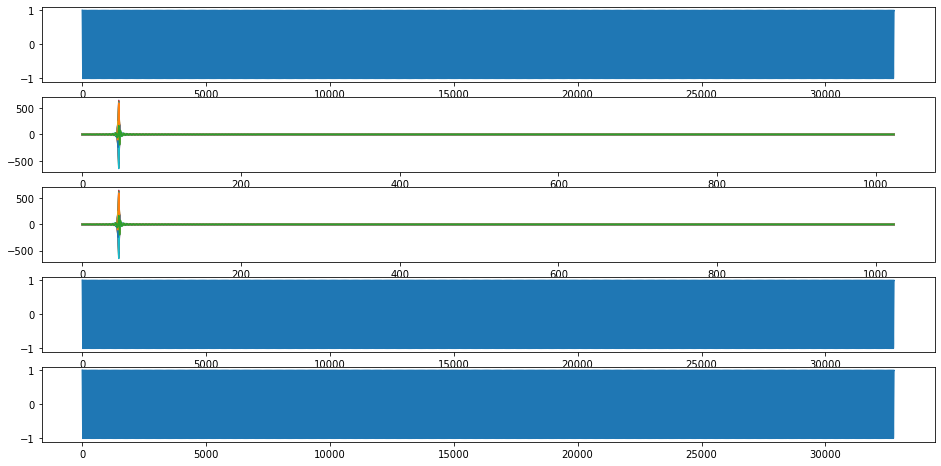

In [6]:
N = 2048
x = np.cos(2*np.pi*np.arange(N*16)/44.1)
my_mdct = MDCT(N, sine_window(N))

mdct_start = time.time()
X = my_mdct.mdct(x)
mdct_end = time.time()
print(f'mdct: {mdct_end - mdct_start}')

mdct_fft_start = time.time()
X_fft = my_mdct.mdct_via_fft(x)
mdct_fft_end = time.time()
print(f'mdct_fft: {mdct_fft_end - mdct_fft_start}')

imdct_start = time.time()
x_hat = my_mdct.imdct(X)
imdct_end = time.time()
print(f'imdct: {imdct_end - imdct_start}')

imdct_fft_start = time.time()
x_hat_fft = my_mdct.imdct_via_ifft(X_fft)
imdct_fft_end = time.time()
print(f'imdct_fft: {imdct_fft_end - imdct_fft_start}')

print(f'erro: {(x - x_hat).sum()}')
print(f'erro_fft: {(x - x_hat_fft).sum()}')
fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize=(16, 8))
ax[0].plot(x)
ax[1].plot(X)
ax[2].plot(X_fft)
ax[3].plot(x_hat)
ax[4].plot(x_hat_fft)

mdct: 0.0035703182220458984
mdct_fft: 0.0011150836944580078
imdct: 0.0026314258575439453
imdct_fft: 0.0011758804321289062
erro: 8.036904475261508e-13
erro_fft: -2.857772907205458e-10


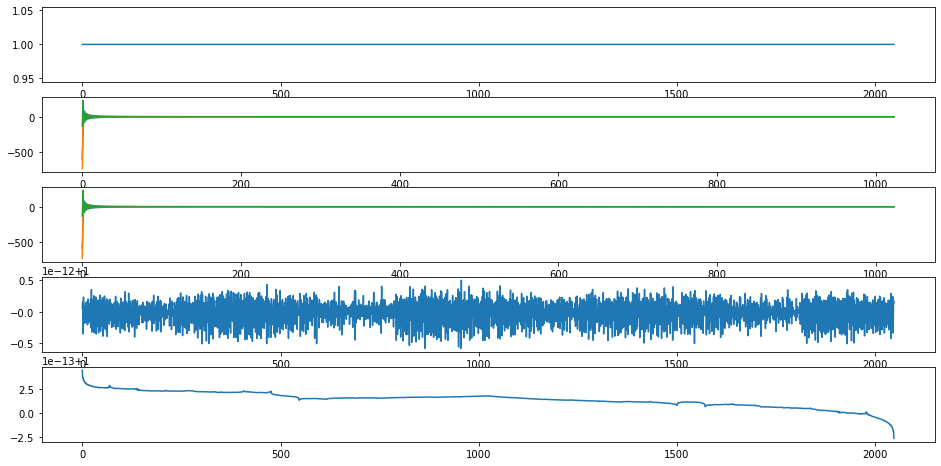

In [7]:
N = 2048
x = np.ones(N)
my_mdct = MDCT(N, sine_window(N))

mdct_start = time.time()
X = my_mdct.mdct(x)
mdct_end = time.time()
print(f'mdct: {mdct_end - mdct_start}')

mdct_fft_start = time.time()
X_fft = my_mdct.mdct_via_fft(x)
mdct_fft_end = time.time()
print(f'mdct_fft: {mdct_fft_end - mdct_fft_start}')

imdct_start = time.time()
x_hat = my_mdct.imdct(X)
imdct_end = time.time()
print(f'imdct: {imdct_end - imdct_start}')

imdct_fft_start = time.time()
x_hat_fft = my_mdct.imdct_via_ifft(X_fft)
imdct_fft_end = time.time()
print(f'imdct_fft: {imdct_fft_end - imdct_fft_start}')

print(f'erro: {(x - x_hat).sum()}')
print(f'erro_fft: {(x - x_hat_fft).sum()}')
fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize=(16, 8))
ax[0].plot(x)
ax[1].plot(X)
ax[2].plot(X_fft)
ax[3].plot(x_hat)
ax[4].plot(x_hat_fft)